
# Random Forest Classification Model(balanced) for shift mit data 
As we concluded before, for PTB data, we apply the following preprocessing:   
Resampling: oversampling   
Scaling: minmax

If you don't have the original files: run the notebook `preprocessing_mit_shift_minmax_oversampling.ipynb`   
Input file:(The preprocessed data)   
mitbih_train_shift_minmax_oversampling.csv   
mitbih_test_shift_minmax_oversampling.csv   

Output: Random Forest Tree model trained  
model_mit_random_forest_shift.pkl  

In [1]:
import sys
import os 

data_path = ''
model_output_path = ''
# check if the enviorment is Google Colab 

if 'google.colab' in sys.modules:
    print("Running on Google Colab")
    # Install required libraries
    !pip install scikit-learn -q
    !pip install pandas -q
    !pip install numpy -q
    !pip install imbalanced-learn -q

    # Mount Google Drive
    from google.colab import drive
    drive.mount('/content/drive')
    # set the path where the csv file stored in your google drive. 
    data_path = '/content/drive/MyDrive/Heartbeat_Project/'
    model_output_path = data_path

else:
    print("Running on local environment")

    current_path = os.getcwd()
    print("Current working directory:", current_path)
    data_path = '../data/processed/'
    model_output_path = '../models/'

   

Running on local environment
Current working directory: c:\Users\Ping\Documents\GitHub\heartbeat-analysis-ai\notebooks


# Read Data

In [2]:
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import f1_score, confusion_matrix, classification_report, roc_curve, auc
from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold, KFold, GridSearchCV
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

RawFiles = dict({
    'test': data_path + 'mitbih_test_shift_minmax_oversampling.csv',
    'train': data_path + 'mitbih_train_shift_minmax_oversampling.csv',
})

OutputFiles = dict({
    'model': model_output_path +  'model_mit_random_forest_shift.pkl'
})


train = pd.read_csv(RawFiles.get('train'),sep=',',header=0)

test = pd.read_csv(RawFiles.get('test'),sep=',',header=0)

y_train = train['target']
X_train = train.drop('target', axis=1)

y_test = test['target']
X_test = test.drop('target', axis=1)



## Optimized Balanced Random Forest Classifier Grid Search

c:\Users\Ping\Documents\GitHub\heartbeat-analysis-ai\.conda\Lib\site-packages\sklearn\model_selection\_validation.py:540: FitFailedWarning: 
60 fits failed out of a total of 180.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
18 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Ping\Documents\GitHub\heartbeat-analysis-ai\.conda\Lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Ping\Documents\GitHub\heartbeat-analysis-ai\.conda\Lib\site-packages\sklearn\base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Us

Balanced RF Best parameters: {'model__max_depth': 20, 'model__max_features': 'sqrt', 'model__min_samples_split': 5, 'model__n_estimators': 100}
Balanced RF Best score: 0.9999172199702635
Balanced RF F1 score: 0.14928898292574916


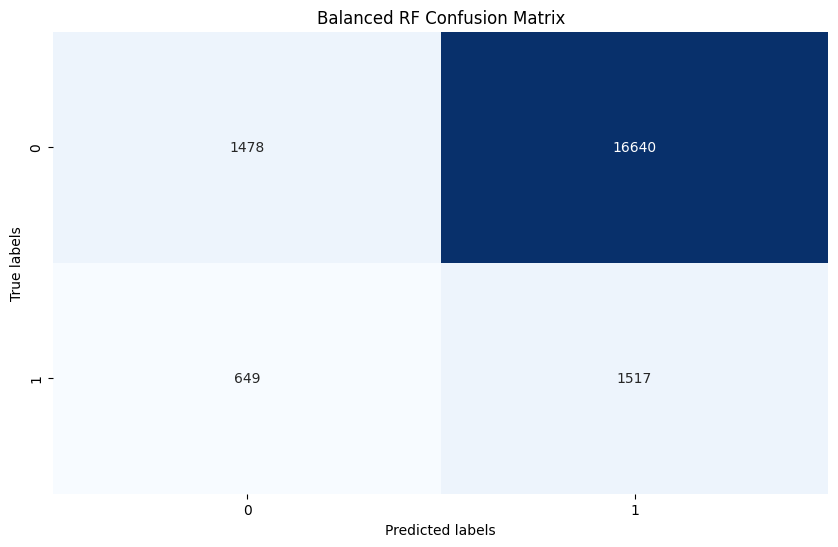

Balanced RF Classification Report:
               precision    recall  f1-score   support

           0       0.69      0.08      0.15     18118
           1       0.08      0.70      0.15      2166

    accuracy                           0.15     20284
   macro avg       0.39      0.39      0.15     20284
weighted avg       0.63      0.15      0.15     20284



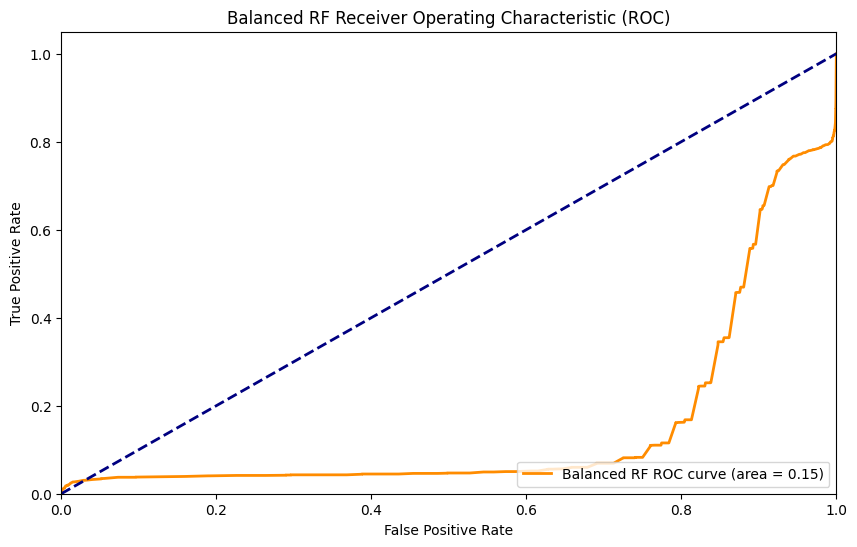

In [3]:
# Balanced Random Forest Classifier
rf_model = RandomForestClassifier(class_weight='balanced', n_jobs=-1)

# Grid parameters for RandomForest
rf_grid_params = {
    'model__n_estimators': [100, 200], # Number of trees in the forest
    'model__max_features': ['auto', 'sqrt', 'log2'], # Number of features to consider at every split
    'model__max_depth': [None, 10, 20], # Maximum number of levels in tree
    'model__min_samples_split': [2, 5] # Minimum number of samples required to split a node
}

# Pipeline for Balanced Random Forest
rf_pipeline = Pipeline([
    ('model', rf_model)
])


# Grid search for Balanced Random Forest
rf_grid_search = GridSearchCV(rf_pipeline, rf_grid_params, cv=5, scoring='f1', n_jobs=-1)

# Fit the Random Forest grid search
rf_grid_search.fit(X_train, y_train)

# Get the best parameters and model for RF
rf_best_params = rf_grid_search.best_params_
print("Balanced RF Best parameters:", rf_best_params)

rf_best_score = rf_grid_search.best_score_
print("Balanced RF Best score:", rf_best_score)

rf_best_model = rf_grid_search.best_estimator_

# Predict and evaluate RF
y_pred_rf = rf_best_model.predict(X_test)
f1_rf = f1_score(y_test, y_pred_rf)
print("Balanced RF F1 score:", f1_rf)

conf_matrix_rf = confusion_matrix(y_test, y_pred_rf)
plt.figure(figsize=(10, 6))
sns.heatmap(conf_matrix_rf, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Balanced RF Confusion Matrix')
plt.show()

class_report_rf = classification_report(y_test, y_pred_rf)
print("Balanced RF Classification Report:\n", class_report_rf)

if len(np.unique(y_test)) == 2:
    y_prob_rf = rf_best_model.predict_proba(X_test)[:, 1]
    fpr_rf, tpr_rf, _ = roc_curve(y_test, y_prob_rf)
    roc_auc_rf = auc(fpr_rf, tpr_rf)

    plt.figure(figsize=(10, 6))
    plt.plot(fpr_rf, tpr_rf, color='darkorange', lw=2, label='Balanced RF ROC curve (area = %0.2f)' % roc_auc_rf)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Balanced RF Receiver Operating Characteristic (ROC)')
    plt.legend(loc='lower right')
    plt.show()
else:
    print("ROC curve is only applicable for binary classification in Balanced RF.")


# Save Best Random Forest (balanced) Model

In [4]:
# Save model 
import pickle
# Save the model to a file
with open(OutputFiles.get('model'), 'wb') as model_file:
    pickle.dump(rf_best_model, model_file)